# Data Overview

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")

KeyboardInterrupt: 

In [104]:
log_dir = Path('../../results/logs/raw-metadata')

In [105]:
categories = ['bacteria', 'fungi', 'viral', 'archaea', 'protozoa']

In [106]:
def load_assembly_summary(file_path: Path, category: str) -> pd.DataFrame:
    """
    Load a NCBI assembly_summary.txt file, handling comment lines and headers.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"{file_path} not found.")
    
    # Extract the header from the comment line
    with open(file_path) as f:
        for line in f:
            if line.startswith("#assembly_accession"):
                header = line.strip("#").strip().split("\t")
                break

    # Now read the file with no header, skipping all comment lines
    df = pd.read_csv(file_path, sep='\t', comment='#', header=None, names=header, low_memory=False)
    df['category'] = category

    # Convert release date column if present
    if 'seq_rel_date' in df.columns:
        df['seq_rel_date'] = pd.to_datetime(df['seq_rel_date'], errors='coerce')

    return df

In [107]:
def load_all_summaries(metadata_dir: Path, categories: list) -> pd.DataFrame:
    dfs = []
    for category in categories:
        file_path = metadata_dir / f"{category}_assembly_summary.txt"
        try:
            df = load_assembly_summary(file_path, category)
            dfs.append(df)
        except FileNotFoundError:
            print(f"[WARNING] Missing: {file_path.name}")
    if not dfs:
        raise ValueError("No valid files loaded.")
    return pd.concat(dfs, ignore_index=True)

In [108]:
def summarize_assembly_levels(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(['category', 'assembly_level']).size().unstack(fill_value=0)

In [109]:
def plot_assembly_level_distribution_by_category(df: pd.DataFrame, output_dir: Path = None):
    """
    Plots individual bar charts for each category showing the assembly level distribution.

    Parameters:
        df (pd.DataFrame): Full metadata DataFrame with 'category' and 'assembly_level' columns.
        output_dir (Path, optional): Directory to save individual plots. If None, just displays them.
    """
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)

    categories = df['category'].unique()
    assembly_order = ["Complete Genome", "Chromosome", "Scaffold"]  # Common order

    for category in sorted(categories):
        sub_df = df[df['category'] == category]
        count_series = sub_df['assembly_level'].value_counts().reindex(assembly_order, fill_value=0)

        plt.figure(figsize=(8, 5))
        sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')

        plt.title(f"Assembly Level Distribution - {category.capitalize()}")
        plt.xlabel("Assembly Level")
        plt.ylabel("Number of Genomes")
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        if output_dir:
            plot_path = output_dir / f"{category}_assembly_levels.pdf"
            plt.savefig(plot_path, bbox_inches='tight')
        plt.show()
        plt.close()

In [110]:
def plot_submissions_over_time(
    df,
    output_path: Path = None,
    train_cutoff: pd.Timestamp = None,
    val_cutoff: pd.Timestamp = None,
    test_cutoff: pd.Timestamp = None
):
    df = df.dropna(subset=['seq_rel_date']).copy()

    plt.figure(figsize=(12, 6))

    # Define consistent palette
    palette = sns.color_palette("Set2", n_colors=df['category'].nunique())
    categories = sorted(df['category'].unique())
    category_palette = dict(zip(categories, palette))

    # Plot each category individually to preserve legend control
    for category in categories:
        sub_df = df[df['category'] == category]
        sns.histplot(
            sub_df,
            x='seq_rel_date',
            bins=60,
            color=category_palette[category],
            label=category,
            element='bars',
            stat='count'
        )

    plt.title("Genome Assembly Submissions Over Time by Category")
    plt.xlabel("Date")
    plt.ylabel("Number of Assemblies")

    # Add cutoff lines if provided
    cutoff_dates = {
        "Train Cutoff": train_cutoff,
        "Val Cutoff": val_cutoff,
        "Test Cutoff": test_cutoff
    }

    for label, date in cutoff_dates.items():
        if date:
            plt.axvline(date, color='black', linestyle='--', label=f"{label}: {date.strftime('%d %b %Y')}")

    plt.legend(title="Category / Cutoffs", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()
    plt.close()

In [111]:
def plot_genome_size_distribution(df, output_path):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df[df['genome_size'] < 1e8], x='category', y='genome_size', density_norm='width', inner='quartile')
    plt.title("Genome Size Distribution by Category")
    plt.ylabel("Genome Size (bp)")
    plt.xlabel("Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

In [112]:
def plot_gc_content_distribution(df, output_path):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df.dropna(subset=['gc_percent']), x='gc_percent', hue='category', fill=True, common_norm=False, alpha=0.5)
    plt.title("GC Content Distribution by Category")
    plt.xlabel("GC Content (%)")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    plt.close()

In [113]:
def plot_gc_content_per_category(df: pd.DataFrame, output_path: Path):
    for cat in df['category'].unique():
        sub = df[df['category'] == cat].copy()

        plt.figure(figsize=(6, 5))
        sns.kdeplot(data=sub.dropna(subset=['gc_percent']), x='gc_percent', fill=True, color='purple', alpha=0.5)
        plt.title(f"{cat.capitalize()} GC Content Distribution")
        plt.xlabel("GC Content (%)")
        plt.tight_layout()
        plt.savefig(output_path / f"{cat}_gc_content.pdf")
        plt.show()
        plt.close()

In [114]:
from datetime import datetime

def run_metadata_analysis(metadata_dir: Path, output_path: Path):
    categories = ["bacteria", "archaea", "viral", "fungi", "protozoa"]
    train_cutoff=pd.Timestamp("2021-12-31"),
    val_cutoff=pd.Timestamp("2022-04-01"),
    test_cutoff=pd.Timestamp("2023-04-01")


    print("[INFO] Loading metadata...")
    df = load_all_summaries(metadata_dir, categories)

    # Filter by release date
    df = df[df['seq_rel_date'] < test_cutoff]
    print(f"[INFO] Filtered dataset to {len(df)} assemblies released before {test_cutoff}.")

    print("[INFO] Summarizing assembly levels...")
    summary = summarize_assembly_levels(df)
    print(summary)
    
    print('[INFO] Plotting assembly levels...')
    plot_assembly_level_distribution_by_category(
                                    df, 
                                     output_dir=Path(output_path)
                                     )


    print("[INFO] Plotting submission trends...")
    plot_submissions_over_time(
        df, 
        output_path / "assembly_submission_trend.pdf",    
        train_cutoff=pd.Timestamp("2021-12-31"),
        val_cutoff=pd.Timestamp("2022-04-01"),
        test_cutoff=pd.Timestamp("2023-04-01")
    ) 

    print("[INFO] Plotting genome size distribution...")
    plot_genome_size_distribution(df, output_path / "genome_size_distribution.pdf")

    print("[INFO] Plotting GC content distribution...")
    plot_gc_content_distribution(df, output_path / "gc_content_distribution.pdf")
    
    print("[INFO] Plotting GC content distribution per category...")
    plot_gc_content_per_category(df, output_path)

    return df, summary

[INFO] Loading metadata...
[INFO] Filtered dataset to 1746533 assemblies released before 2023-04-01 00:00:00.
[INFO] Summarizing assembly levels...
assembly_level  Chromosome  Complete Genome   Contig  Scaffold
category                                                      
archaea                 86              592     8408      5205
bacteria              6193            38384  1284758    222689
fungi                 1009              299     4204      8443
protozoa               184               22      562      1072
viral                 6927           147132    10315        49
[INFO] Plotting assembly levels...


/var/folders/2h/mkjskkzn4rg586w85_sqck440000gn/T/ipykernel_4063/2278617637.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')


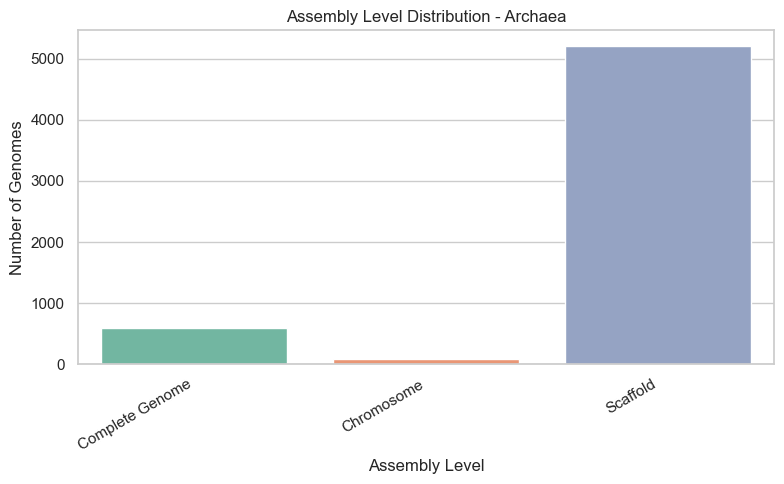

/var/folders/2h/mkjskkzn4rg586w85_sqck440000gn/T/ipykernel_4063/2278617637.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')


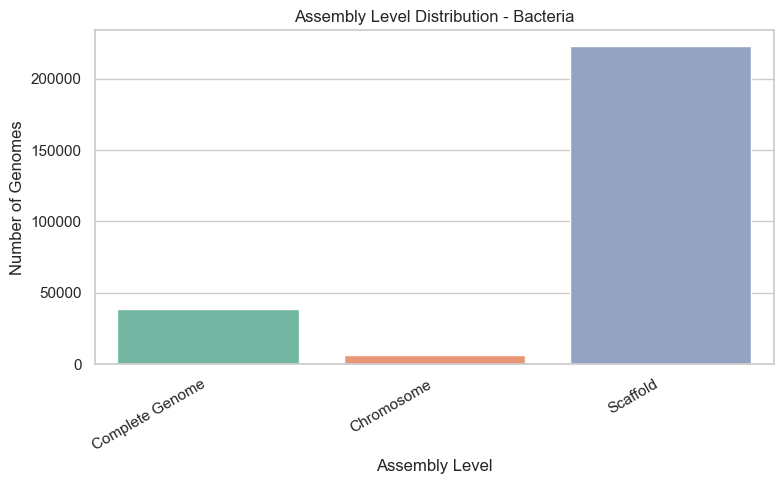

/var/folders/2h/mkjskkzn4rg586w85_sqck440000gn/T/ipykernel_4063/2278617637.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')


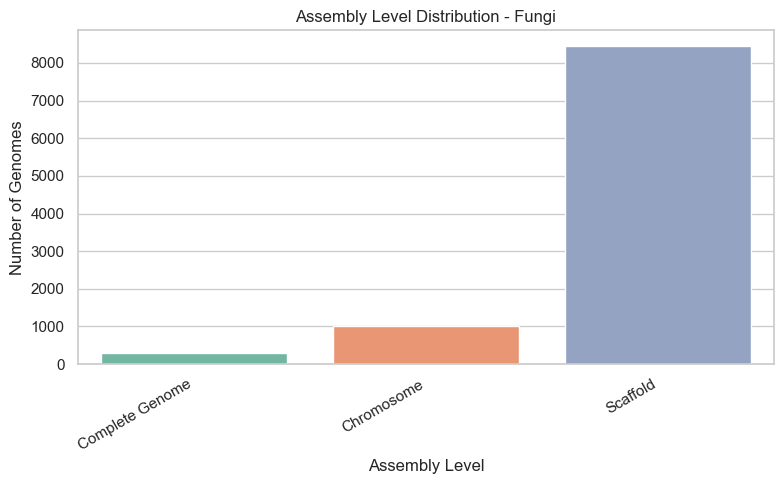

/var/folders/2h/mkjskkzn4rg586w85_sqck440000gn/T/ipykernel_4063/2278617637.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')


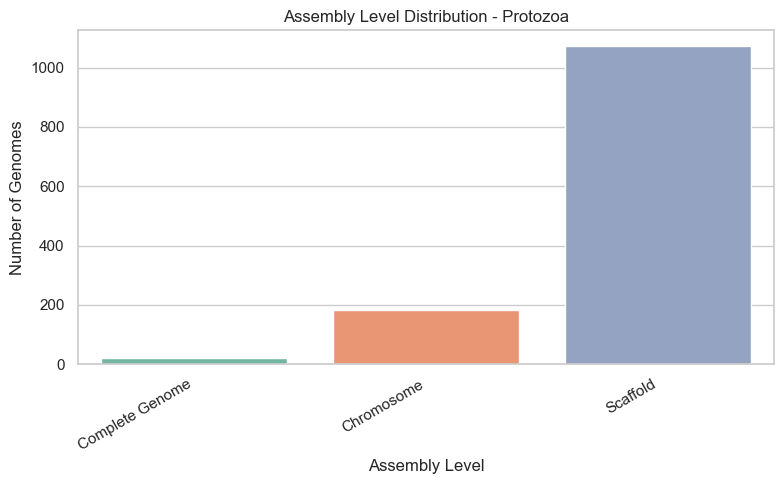

/var/folders/2h/mkjskkzn4rg586w85_sqck440000gn/T/ipykernel_4063/2278617637.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_series.index, y=count_series.values, palette='Set2')


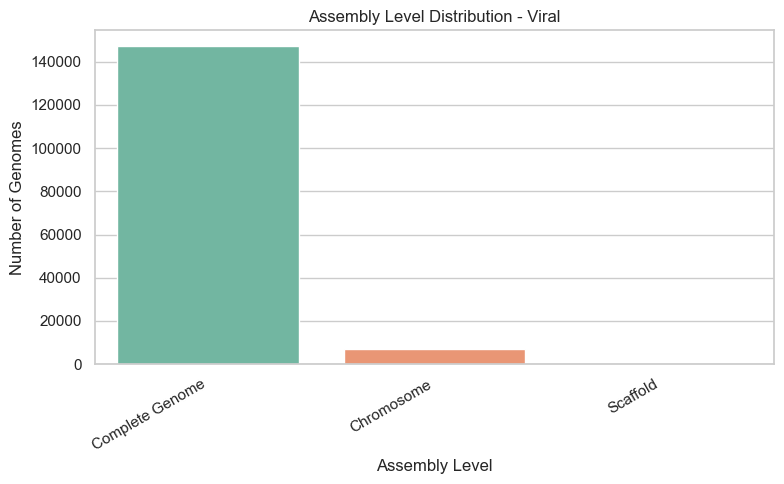

[INFO] Plotting submission trends...


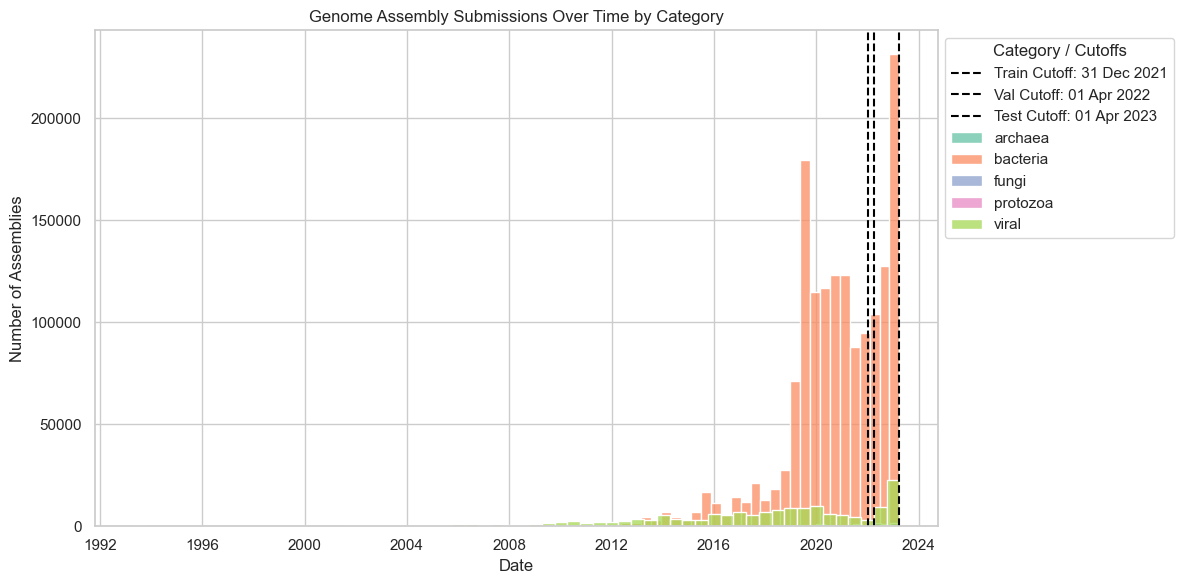

[INFO] Plotting genome size distribution...


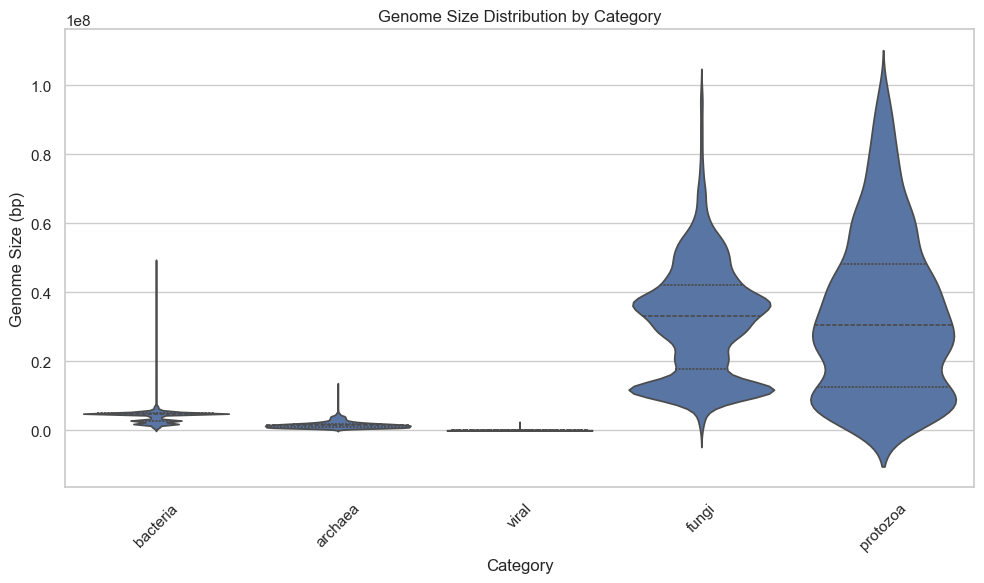

[INFO] Plotting GC content distribution...


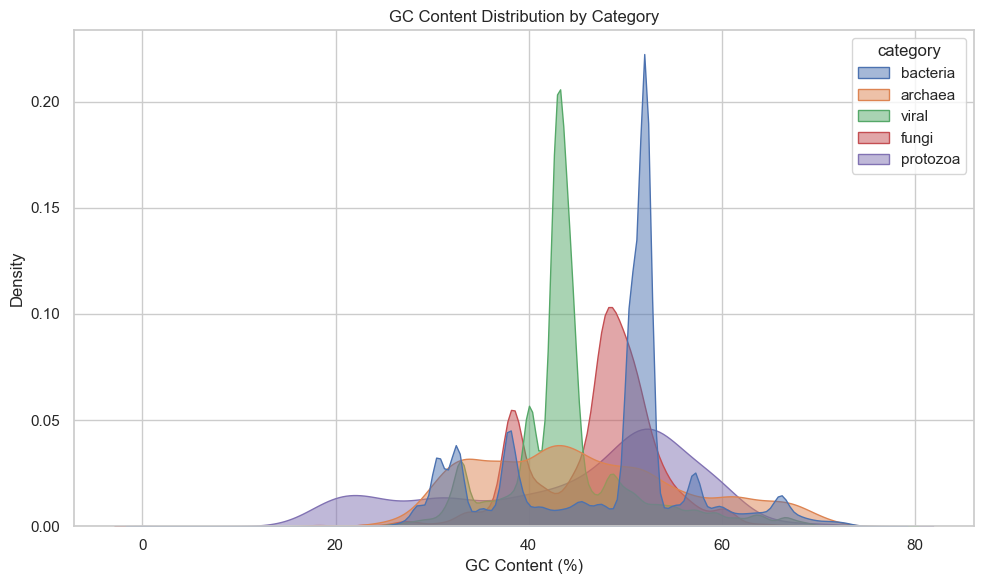

[INFO] Plotting GC content distribution per category...


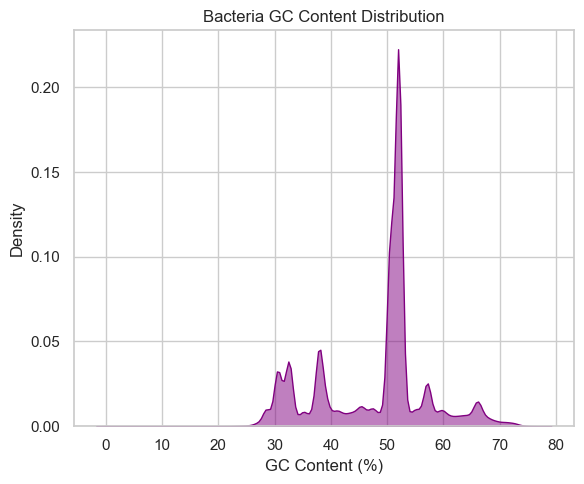

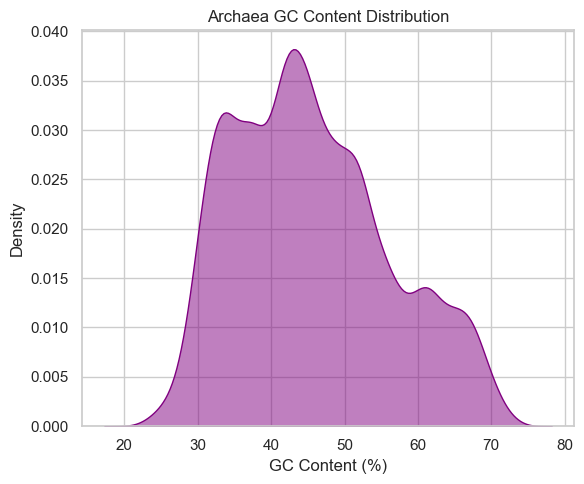

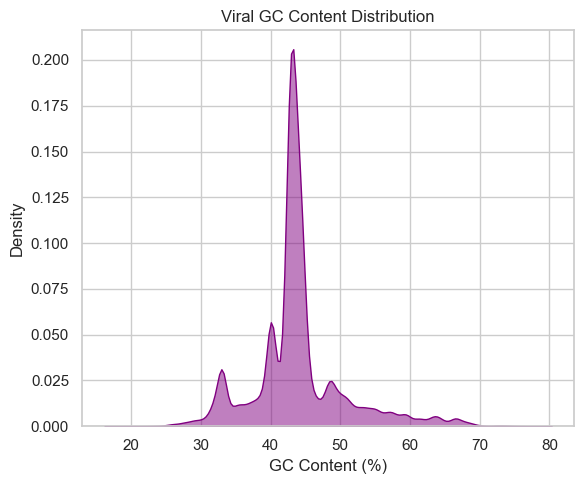

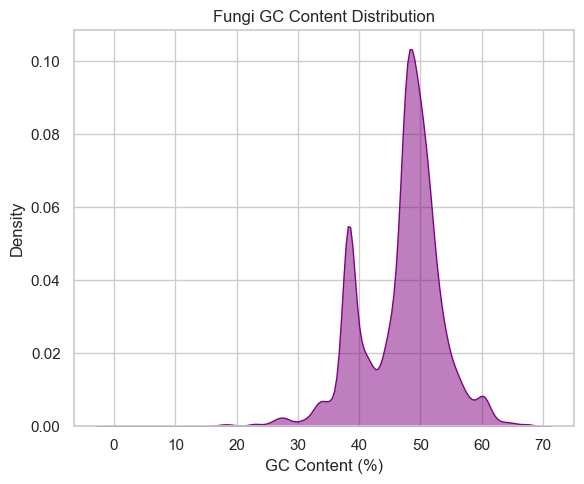

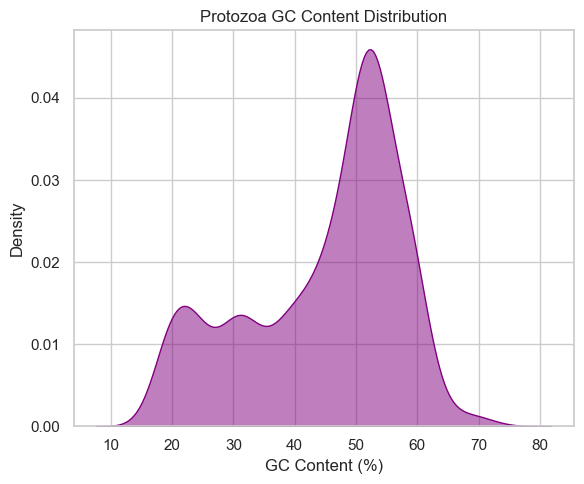

In [115]:
output_path = Path('../../figures')
df, summary = run_metadata_analysis(log_dir, output_path)